In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
import os 
import torch 
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from usr_func import read_file, synchronize_data, make_subplot_data, preprocess_data, split_train_val_test_data, create_sequences, train_the_model, make_subplots_1, make_subplots_2, make_subplots_with_zones
from model.LSTMAutoEncoder import LSTMAutoEncoder

%reload_ext autoreload
%autoreload 2

folder_path = r"C:\Users\nq9093\Downloads\CutFilesToYaolin\CutFilesToYaolin"
files = os.listdir(folder_path)
figpath = os.path.join(os.getcwd(), 'fig')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [6]:
filenames = []
for file in files: 
    if file.endswith(".cut"): 
        filenames.append(file[:-4])
        file = filenames[0]

# for file in tqdm(filenames): 
#     filepath = os.path.join(folder_path, file)
#     df_accelerometer, df_strain0, df_strain1 = read_file(filepath)
#     df_sync = synchronize_data(df_accelerometer, df_strain0, df_strain1)
#     fig = make_subplot_data(df_sync, filepath, figpath, show=False, save=True)


In [7]:
file = filenames[0]
filepath = os.path.join(folder_path, file)
df_accelerometer, df_strain0, df_strain1 = read_file(filepath)
df_sync = synchronize_data(df_accelerometer, df_strain0, df_strain1)
fig = make_subplot_data(df_sync, filepath, figpath, show=False, save=False)

In [8]:
t_start = 8
t_end = 18
df_selected = df_sync[(df_sync.iloc[:, 0] >= t_start) & (df_sync.iloc[:, 0] <= t_end)]
df_scaled = preprocess_data(df_selected)

df_train, df_val, df_test = split_train_val_test_data(df_scaled, 0.8, .1, .1)

sequence_length = 30
batch_size = 32

columns = ['x2g', 'y2g', 'z2g', 'x50g', 'y50g', 'strain0', 'strain1']
train_dataset = create_sequences(df_train[columns].values, sequence_length)
val_dataset = create_sequences(df_val[columns].values, sequence_length)
test_dataset = create_sequences(df_test[columns].values, sequence_length)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = LSTMAutoEncoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [9]:
model, train_losses, val_losses = train_the_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=30)


  3%|▎         | 1/30 [00:01<00:43,  1.49s/it]

Epoch 1/30: Train Loss: 0.025824743823613973, Val     Loss: 0.014735312163829804


 37%|███▋      | 11/30 [00:14<00:24,  1.30s/it]

Epoch 11/30: Train Loss: 0.0008426489794510416, Val     Loss: 0.0008121933019720018


 70%|███████   | 21/30 [00:27<00:11,  1.25s/it]

Epoch 21/30: Train Loss: 0.00012967656011824146, Val     Loss: 0.00011219463369343429


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]

Test Loss: 8.148966167937033e-05


In [2]:
# plt.plot(train_losses, label='train')
# plt.plot(val_losses, label='val')
# plt.legend()
# plt.show()

In [10]:
pred_train = model(train_dataset[:][0])
pred_val = model(val_dataset[:][0])
pred_test = model(test_dataset[:][0])

predTrain = pred_train.detach().cpu().numpy()[:, -1, :]
predVal = pred_val.detach().cpu().numpy()[:, -1, :]
predTest = pred_test.detach().cpu().numpy()[:, -1, :]

timestamp_train = df_train.iloc[sequence_length:, 0]
timestamp_val = df_val.iloc[sequence_length:, 0]
timestamp_test = df_test.iloc[sequence_length:, 0]

df_pred_train = pd.DataFrame(predTrain, columns=columns)
df_pred_train['timestamp'] = timestamp_train.values
df_pred_val = pd.DataFrame(predVal, columns=columns)
df_pred_val['timestamp'] = timestamp_val.values
df_pred_test = pd.DataFrame(predTest, columns=columns)
df_pred_test['timestamp'] = timestamp_test.values

In [11]:
df_sync_scaled = preprocess_data(df_sync)
merged_dataset = create_sequences(df_sync_scaled[columns].values, sequence_length)

# make_subplot_data(df_sync_scaled, filepath, figpath, show=True, save=False)
# prediction = model(merged_dataset[:][0])

In [12]:
N_split = 5000
counter = 0
pred = np.empty([0, sequence_length, len(columns)])
for i in range(0, len(merged_dataset), N_split): 
    result = model(merged_dataset[i:i+N_split][0])
    pred = np.append(pred, result.detach().cpu().numpy(), axis=0)

In [13]:
pred_flatten = pred[:, -1, :]
timestamp_all = df_sync_scaled.iloc[sequence_length:, 0]
df_pred_all = pd.DataFrame(pred_flatten, columns=columns)
df_pred_all['timestamp'] = timestamp_all.values

# fig1 = make_subplots_1(df_sync_scaled, line_color='black', title='Original Data')
# fig2 = make_subplots_2(df_pred_all, line_color='red', fig=fig1, title='Predicted Data')
# fig2.show()

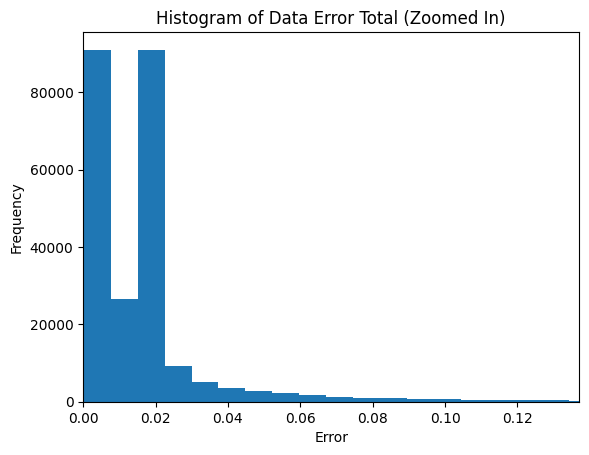

In [17]:
df_original = df_sync_scaled.iloc[sequence_length:, :]
df_original.head()

data_original = df_original[columns].values
data_pred = df_pred_all[columns].values
data_error = (data_original - data_pred) ** 2
df_error = pd.DataFrame(data_error, columns=columns)
df_error['timestamp'] = timestamp_all.values

data_error_total = np.sum(data_error, axis=1)
threshold = .025
anomaly = data_error_total > threshold
plt.hist(data_error_total, bins=100)
plt.xlim(0, np.percentile(data_error_total, 99))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Data Error Total (Zoomed In)')
plt.show()


In [18]:

def cluster_anomalies(anomaly_indices, max_gap):
    if not anomaly_indices:
        return []
    anomaly_indices = sorted(anomaly_indices)
    zones = []
    zone_start = anomaly_indices[0]
    
    for i in range(1, len(anomaly_indices)):
        if anomaly_indices[i] - anomaly_indices[i - 1] > max_gap:
            # Close the current zone and start a new one
            zone_end = anomaly_indices[i - 1]
            zones.append((zone_start, zone_end))
            zone_start = anomaly_indices[i]
    
    # Don't forget to append the last zone
    zones.append((zone_start, anomaly_indices[-1]))
    
    return zones

# Example usage
anomaly_indices = np.where(anomaly)[0].tolist()
max_gap = 800
zones = cluster_anomalies(anomaly_indices, max_gap)
print(len(zones))

29


In [20]:
# fig3 = make_subplots_1(df_original, line_color='black', title='Original Data')
# fig4 = make_subplots_2(df_original[anomaly], line_color='red', mode="markers", fig=fig3, title='Anomaly Data')
# fig4.show()
# fig = make_subplots_with_zones(df_original, line_color='black', title='Original Data', zones=zones)
# fig.show()

In [27]:
import numpy as np 
import matplotlib.pyplot as plt
import ruptures as rpt 

n = 50000
n_bkps, sigma = 7, 5
signal, bkps = rpt.pw_constant(n, n_bkps, noise_std=sigma)

model = "l2"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(pen=500)

for i in range(signal.shape[1]): 
    plt.subplot(signal.shape[1], 1, i+1)
    plt.plot(signal[:, i])
    for k in my_bkps: 
        plt.axvline(x=k, color='red')
plt.show()


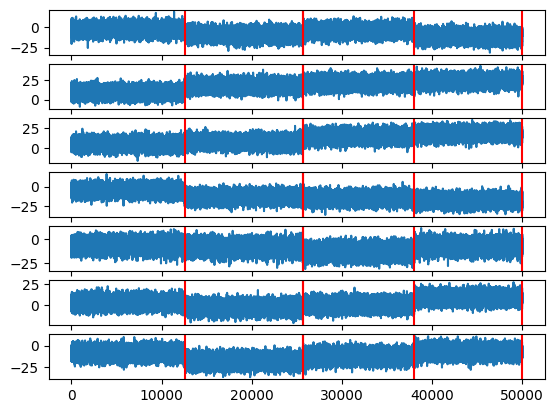

In [1]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity




In [3]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

In [4]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

In [5]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         0.59%       4.446ms       100.00%     758.016ms     758.016ms             1  
                     aten::linear         0.00%      26.000us        90.54%     686.279ms     686.279ms             1  
                      aten::addmm        90.52%     686.184ms        90.53%     686.212ms     686.212ms             1  
                     aten::conv2d         0.02%     129.000us         6.82%      51.714ms       2.586ms            20  
                aten::convolution         0.06%     423.000us         6.81%      51.585ms       2.579ms            20  
               aten::_convolution       

In [6]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         0.59%       4.446ms       100.00%     758.016ms     758.016ms             1                                                                                []  
                     aten::linear         0.00%      26.000us        90.54%     686.279ms     686.279ms             1                                                   [[5, 512], [1000, 512], 